In [206]:
import numpy as np
from numpy import linalg as LA
from copy import deepcopy
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline
from sklearn.metrics import log_loss

from IPython.display import display as d

In [144]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((1, 0, 2)).reshape(784, -1)
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz").reshape((1, -1))
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((1, 0, 2)).reshape(784, -1)
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz").reshape((1, -1))

In [145]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(784, 12000)
(1, 12000)
(784, 1000)
(1, 1000)


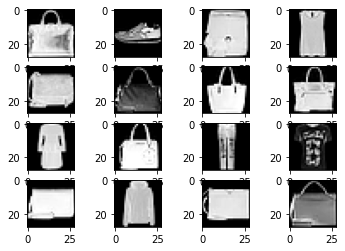

In [146]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[:, np.random.randint(0, len(devxs))].reshape(28, 28))

In [93]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def dSigmoid(Z):
    s = sigmoid(Z)
    return s * (1 - s)

In [261]:
class twolp:
    def __init__(self, xs, ys):
        self.X = xs
        self.Y = ys
        self.Yh = np.zeros((5, self.Y.shape[1]))
        
        self.L = 2
        self.dims = [28**2, 23, 1]
        
        self.param = {}
        self.ch = {} #cache
        self.grad = {}
        
        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.lr = 0.1
        self.nData = self.Y.shape[1]
        
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['w2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return
    
    def nloss(self,Yh):
        loss = (1./self.nData) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss
    
    def forward(self):
        Z1 = self.param["W1"] @ self.X + self.param["b1"]
        A1 = sigmoid(Z1)
        self.ch["Z1"], self.ch["A1"] = Z1, A1
        
        Z2 = self.param["w2"] @ A1 + self.param["b2"]
        A2 = sigmoid(Z2)
        self.ch["Z2"], self.ch["A2"] = Z2, A2
        
        self.Yh = A2
        loss = log_loss(self.Y, A2)# self.nloss(A2)
        return self.Yh, loss
    
    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2']) 
        dLoss_A1 = np.dot(self.param["w2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dSigmoid(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["w2"] = self.param["w2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        
    def predict_mlp(self, xs, i):
        Z1 = self.param["W1"] @ xs + self.param["b1"]
        A1 = sigmoid(Z1)
        
        Z2 = self.param["w2"] @ A1 + self.param["b2"]
        A2 = sigmoid(Z2)
        
        if A2[:, i] >= 0.5:
            return 1
        return 0
    
    def get_accuracy(self, devxs, devys):
        accuracy = 0
        for i in range(devxs.shape[1]):
            yp = self.predict_mlp(devxs, i)
            if (yp == devys[:, i]):
                accuracy += 1
        return (accuracy / devys.shape[1]) * 100
        
    def validation_loss(self, devxs, devys):
        l = 0
        params = self.param
        for i in range(devxs.shape[1]):
            yprime = self.predict_mlp(devxs, i)
            if (yprime == 0 and devys[:, i] == 1):
                yprime += 1e-15
            elif yprime == 1 and devys[:, i] == 0:
                yprime -= 1e-15
            if devys[:, i] == 1:
                l += np.log(yprime)
            else:
                l += np.log(1 - yprime)
        return ((-1) / devys.shape[1]) * l
    
    def train(self, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
            
            
        
            if i % 100 == 0:
                
                val_loss = self.validation_loss(devxs, devys)
                accuracy = self.get_accuracy(devxs, devys)
                self.loss.append(loss)
                self.val_loss.append(val_loss)
                self.accuracy.append(accuracy)
                print ("Cost after iteration %i: %f, accuracy: %f" %(i, val_loss, accuracy))
    
        return

In [262]:
nn = twolp(trainxs, trainys)
nn.train()


Cost after iteration 0: 17.097090, accuracy: 50.500000
Cost after iteration 100: 2.245049, accuracy: 93.500000
Cost after iteration 200: 1.381564, accuracy: 96.000000
Cost after iteration 300: 1.381565, accuracy: 96.000000
Cost after iteration 400: 1.347025, accuracy: 96.100000
Cost after iteration 500: 1.243409, accuracy: 96.400000
Cost after iteration 600: 1.208870, accuracy: 96.500000
Cost after iteration 700: 1.174331, accuracy: 96.600000
Cost after iteration 800: 1.174331, accuracy: 96.600000
Cost after iteration 900: 1.105253, accuracy: 96.800000
Cost after iteration 1000: 1.105253, accuracy: 96.800000
Cost after iteration 1100: 1.036175, accuracy: 97.000000
Cost after iteration 1200: 1.001636, accuracy: 97.100000
Cost after iteration 1300: 1.001636, accuracy: 97.100000
Cost after iteration 1400: 1.001636, accuracy: 97.100000
Cost after iteration 1500: 0.932557, accuracy: 97.300000
Cost after iteration 1600: 0.932557, accuracy: 97.300000
Cost after iteration 1700: 0.932557, accur

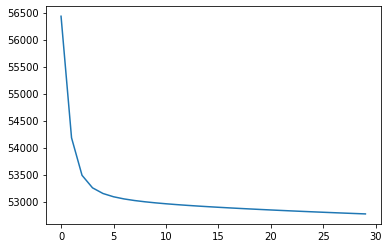

In [264]:
pltOne(nn.loss)

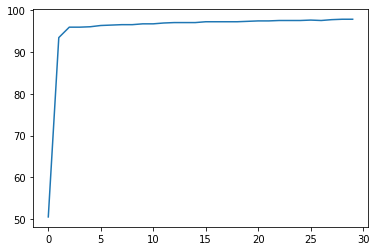

In [263]:
pltOne(nn.accuracy)

In [230]:
def get_loss(m):
    res = []
    for i in m.val_loss:
        res.append(i.item())
    return res

In [193]:
def pltOne(d):
    plt.plot(range(len(d)), d)

In [231]:
loss_lr_0_1_ks = get_loss(nn)

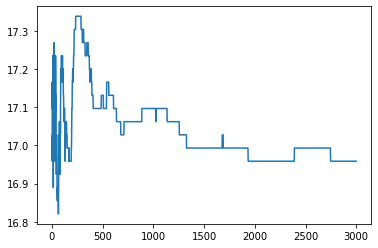

In [232]:
pltOne(loss_lr_0_1_ks)

In [210]:
loss_lr_0_1_skl = get_loss(nn)

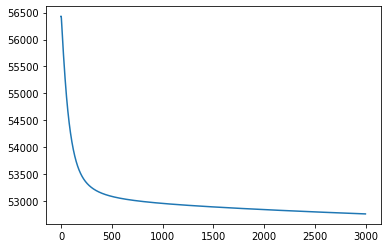

In [211]:
pltOne(loss_lr_0_1_skl)

In [204]:
loss_lr_0_1 = get_loss(nn)

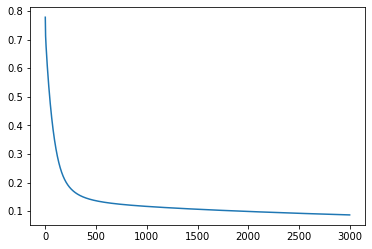

In [205]:
pltOne(loss_lr_0_1)

In [196]:
loss_lr_0_01# = get_loss(nn)

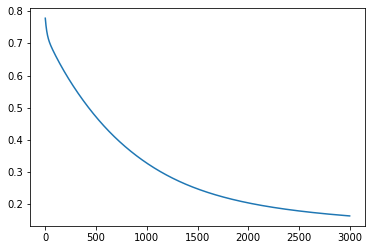

In [197]:
pltOne(loss_lr_0_01)

In [200]:
loss_lr_0_001# = get_loss(nn)

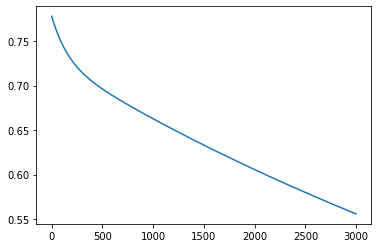

In [201]:
pltOne(loss_lr_0_001)